In [ ]:
#load rpy2 magic
%load_ext rpy2.ipython

# to switch off warning messages
import warnings
warnings.filterwarnings("ignore")

# make default cell width 85% of available screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

# load R libraries & functions
%R options(warn=-1)
%R library(RColorBrewer)
%R library(ComplexHeatmap)
%R library(circlize)
%R library(dendextend)
%R library(Rtsne)
%R library(ggplot2)
%R library(gridExtra)
%R source("/gfs/devel/tkhoyratty/my_scripts/R/pca.R")
%R Palette <- c("#E69F00", "#0072B2", "#D55E00", "#009E73",  "#56B4E9",  "#999999", "#F0E442")

# load python modules
import glob
import re
import sys
import os
import rpy2.robjects as robjects
import CGAT.Database as DB
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

db = "./csvdb"

# ATAC Pipeline Report

In [ ]:
# get peak/readcounts to use from pipeline.ini
with open("pipeline.ini", "r") as o:
    for line in o:
        match = re.findall("^peaks=.*", line)
        if len(match) > 0:  
            filt = ''.join([x.split("=")[-1] for x in match])

# import counts & upper quantile normalise
def get_counts(filt=filt, db=db):
    # get counts, filter on fragment size

    if filt == "size_filt":
        peaks = "<150bp"
    if filt == "all":
        peaks = "all_fragments"
        
    statement = '''select sample_id, peak_id, RPM_width_norm *1000 as RPM 
                from all_norm_counts where size_filt == "%(peaks)s" ''' % locals()
        
    df = DB.fetch_DataFrame(statement, db)

    df = df.pivot("sample_id", "peak_id", "RPM").transpose()
    df.index.name = None

    # normalise to upper quantiles for between sample comparison
    df = df.div(df.quantile(0.75, axis=0), axis=1) 
    
    return df

counts = get_counts()

In [ ]:
# Get sample information
sample_info = DB.fetch_DataFrame('''select * from sample_info''', db)
sample_info["replicate"] = sample_info["replicate"].apply(lambda x: str(x))
sample_info.index = sample_info["category"]
sample_info.index.name = None

## Mapping QC
* All mapped reads are contained in "genome"
* "filt" contains reads with MAPQ scores >10 & has reads mapping to chrM subtracted
* Reads in "prep" have PCR duplicates subtracted
* "prep<150bp" files are further filtered for reads with insert sizes < 150 b.p.

In [ ]:
def mapping_stats(paired=True, db=db, sample_info=sample_info):
    '''Collect all mapping stats & retrun df for plotting'''
    
    if paired==True:
        reads = DB.fetch_DataFrame('''select READS_ALIGNED_IN_PAIRS/2 as MAPPED_PAIRS, PCT_READS_ALIGNED_IN_PAIRS, 
                                      TOTAL_READS, PCT_ADAPTER, sample_id from picardAlignmentSummary 
                                      where CATEGORY = "PAIR" ''', db)
    if paired==False:
        print "Update function for non-paired data"
    
    # Format mapping qc df
    reads["Filter"] = reads["sample_id"].apply(lambda x: x.split(".")[-1])
    reads["Filter"] = reads["sample_id"].apply(lambda x: x.split("_")[-1] if "size_filt_prep" not in x else "prep<150bp")
    reads["sample_id"] = reads["sample_id"].apply(lambda x: '_'.join(x.split("_")[0:-1]))
    reads["sample_id"] = reads["sample_id"].apply(lambda x: x.split(".")[0])

    if len(sample_info)==0:
        print "Provide sample_info df with sample annotations"
        
    reads = pd.merge(reads, sample_info, on="sample_id", how="inner")
    
    # get no. reads mapping to chrM
    chrm = DB.fetch_DataFrame('''select * from allContig''', db)
    
    # reformat df
    chrm = chrm.pivot("sample_id", "contig", "mapped_reads")
    chrm["total_mapped_reads"] = chrm.sum(axis=1)
    chrm["sample_id"] = chrm.index.values
    chrm.index.name = None
    chrm = chrm[["chrM", "total_mapped_reads", "sample_id"]]
    chrm["pct_chrM"] = chrm["chrM"] / chrm["total_mapped_reads"] *100 # % reads mapping to chrM

    # annotate df
    chrm["sample_id"] = chrm["sample_id"].apply(lambda x: str(x).split(".")[0])
    chrm = pd.merge(chrm, sample_info, on="sample_id", how="inner")
    chrm["Filter"] = "genome" # chrM only in genomic reads as filtered out after, others not tested

    df = pd.merge(reads, chrm[["pct_chrM", "sample_id", "Filter"]], how="outer", on=["sample_id", "Filter"])
    
    return df

mapping_qc = mapping_stats()

In [ ]:
%%R

# R functions

get_legend <- function(a.gplot){ 
  tmp <- ggplot_gtable(ggplot_build(a.gplot)) 
  leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box") 
  legend <- tmp$grobs[[leg]] 
  return(legend)
} 

theme_Publication <- function(base_size=18, base_family="helvetica") {
                  (theme_set(theme_minimal(base_size=18))
                  + theme(plot.title = element_text(face = "bold",
                                                 size = rel(1.2), hjust = 0.5),
                             text = element_text(),
                             panel.background = element_rect(colour = NA),
                             plot.background = element_rect(colour = NA),
                             axis.title = element_text(face = "bold",size = rel(1)),
                             axis.title.y = element_text(angle=90,vjust=2, size=20),
                             axis.title.x = element_text(vjust=-0.2, size=20),
                             axis.text = element_text(size=20),
                             axis.line = element_line(colour="black"),
                             axis.ticks = element_line(),
                             panel.grid.major = element_line(colour="#f0f0f0"),
                             panel.grid.minor = element_blank(),
                             legend.key = element_rect(colour = NA),
                             legend.position = "bottom",
                             legend.direction = "horizontal",
                             legend.key.size= unit(0.5, "cm"),
                             legend.margin = unit(0.5, "cm"),
                             legend.title = element_text(face="italic"),
                             plot.margin=unit(c(10,5,5,5),"mm"),
                             strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
                             strip.text = element_text(face="bold")
                             ))
}

ggplot_prcomp <- function(prcomp_object,
                          plots=list("A"=c("PC1","PC2"), "B"=c("PC3","PC4"), "C"=c("PC5","PC6")),
                          sample_information="none",
                          color="c()",
                          shape="c()",
                          label="none",
                          size=3,
                          nudge_scale_factor=40)
{
require(gridExtra)
pca = prcomp_object

# sample_information should have the same rownames as pca$x
pvs <- summary(pca)$importance["Proportion of Variance",]

names = paste(names(pvs)," (",round(pvs,2),")",sep="")

#scree plot
fs <- data.frame(x=c(1:length(names(pvs))), y=as.vector(pvs))

#     pcdf <- as.data.frame(pca$x)
pca_n <- dim(pca$rotation)[1]
pcdf <- as.data.frame(pca$rotation[, 1:pca_n])

print("1")
#     if(sample_information!="none") {
pcdf <- merge(pcdf, sample_information, by=0, all=T)
#     }
print("2")
gps = list()

scree <- ggplot(fs, aes(x,y)) + geom_point(size=4) + xlab("principal component") + ylab("proportion of variance") + ggtitle("scree plot")

c_lab <- function(props, C)
{
return(paste(C, " (", props[[C]]*100,"%)",sep=""))
}

for(plot in names(plots))
{

comps <- plots[[plot]]

PCX <- comps[1]

PCY <- comps[2]
    
#print(head(pcdf))

nudge_x <- diff(range(pcdf[[PCX]]))/nudge_scale_factor
nudge_y <- diff(range(pcdf[[PCY]]))/nudge_scale_factor

#if(length(color)==0) {color="black"}
#if(length(shape)==0) {shape=19}
gp <- ggplot(pcdf, aes_string(PCX, PCY, color=color, shape=shape))


if(label!="none")
{
gp <- gp + geom_text(aes_string(label=label), nudge_x=nudge_x, nudge_y=nudge_y, color="black")
}

gp <- gp + geom_point(size=size)
gp <- gp + xlab(c_lab(pvs,PCX)) + ylab(c_lab(pvs,PCY))

gps[[plot]] <- gp

}

gps[["scree"]] <- scree

return(gps)

}

In [ ]:
%%R -i mapping_qc -w 800 -h 600

test <- ggplot(mapping_qc, aes(y=MAPPED_PAIRS, x=sample_id, colour=condition, shape=Filter)) + 
        geom_point(size=6) + 
        theme_Publication()
        
a <- ggplot(mapping_qc, aes(y=MAPPED_PAIRS, x=sample_id, colour=condition, shape=Filter)) + 
        geom_point(size=6) + 
        theme_Publication() + 
        theme(axis.text.x=element_blank()) +
        scale_y_continuous(limits=c(0, 65000000)) +
        scale_colour_manual(values=Palette) +
        labs(x="", y="Mapped Pairs") +
        geom_hline(yintercept=25000000, lty="dashed", col="black")

b <- ggplot(subset(mapping_qc, Filter=="genome"), 
            aes(y=PCT_READS_ALIGNED_IN_PAIRS*100, x=sample_id, colour=condition)) + 
        geom_point(size=6, shape=17) + 
        theme_Publication() + 
        theme(axis.text.x=element_blank()) +
        labs(y="% Reads in Pairs", x="") +
        scale_y_continuous(limits=c(0, 100)) +
        scale_colour_manual(values=Palette)

c <- ggplot(mapping_qc, aes(y=PCT_ADAPTER, x=sample_id, colour=condition, shape=Filter)) + 
        geom_point(size=6) + 
        theme_Publication() + 
        theme(axis.text.x=element_blank()) +
        scale_colour_manual(values=Palette) +
        labs(x="", y="% Adaptor")

d <- ggplot(mapping_qc, aes(y=pct_chrM, x=sample_id, colour=condition)) + 
        geom_point(size=6, shape=17) +
        theme_Publication() +
        labs(x="", y= "% chrM Reads") +
        scale_y_continuous(limits=c(0,100)) +
        theme(axis.text.x=element_blank()) +
        scale_colour_manual(values=Palette)

legend <- get_legend(a)

grid.arrange(a + theme(legend.position="none"), b + theme(legend.position="none"), 
             c + theme(legend.position="none"), d + theme(legend.position="none"), 
             ncol=2, nrow=2, bottom=legend)

## Insert sizes

In [ ]:
def fragment_stats(db=db, sample_info=sample_info):
    '''Collect insert size stats & format df for plotting'''
    
    def clean(df):
        df["Filter"] = df["sample_id"].apply(lambda x: x.split(".")[-1])
        df["Filter"] = df["sample_id"].apply(lambda x: x.split("_")[-1] if "size_filt_prep" not in x else "prep<150bp")
        df["sample_id"] = df["sample_id"].apply(lambda x: x.rstrip("_prep"))
        df["sample_id"] = df["sample_id"].apply(lambda x: x.split(".")[0])
        df = pd.merge(df, sample_info, on="sample_id", how="inner")
        return df
    
    insert_sizes = DB.fetch_DataFrame('''select * from picardInsertSizeHistogram where sample_id like "%prep"''', db)
    size_stats = DB.fetch_DataFrame('''select * from picardInsertSizeMetrics where sample_id like "%prep"''', db)

    insert_sizes = clean(insert_sizes)
    size_stats = clean(size_stats)

    return [size_stats, insert_sizes]

(size_stats, insert_sizes) = fragment_stats()

In [ ]:
%%R -i insert_sizes,size_stats -w 800 -h 800

a <- ggplot(insert_sizes, aes(y=All_Reads_fr_count, x=insert_size)) + 
        geom_bar(stat="identity") +
        scale_fill_manual(values=Palette) +
        scale_x_continuous(limits=c(0, 800)) + 
        labs(y="No. Fragments", x="Fragment length (b.p.)") +
        theme_Publication() + facet_wrap(~ Filter)

c <- ggplot(insert_sizes, 
            aes(x=category, y=insert_size, fill=condition, alpha=factor(replicate))) + 
        geom_boxplot() +
        scale_fill_manual(values=Palette) +
        coord_cartesian(y=c(0, 1000)) + 
        labs(y="Fragment length (b.p.)", x="Sample") +
        theme_Publication() +
        scale_alpha_discrete(range=c(0.5,1), name="replicate") +
        theme(axis.text.x=element_blank())  + facet_wrap(~ Filter)

grid.arrange(a, c, ncol=1, nrow=2)

## TSS Enrichment
### Normalised ATAC signal over all TSSs

All_fragments | Size_filt
- | -
![alternate text](deeptools.dir/TSS.all.profile.png) | ![alternate text](deeptools.dir/TSS.size_filt.profile.png)

### Called peaks relative to nearest TSS

In [4]:
def get_tss_dist(db=db):

    statement = '''select distinct a.sample_id, a.peak_id, a.size_filt, c.strand || "" || b.TSSdist as TSSdist
                from all_norm_counts a, merged_peaks_GREAT_annotated b,
                ensemblGeneset c where a.peak_id = b.peak_id 
                and b.gene_id = c.gene_id ''' % locals()
        
    # and a.size_filt == "%(peaks)s"
    
    df = DB.fetch_DataFrame(statement, db)
    
    df["TSSdist"] = df["TSSdist"].astype(int)
    
    return df
    
df = get_tss_dist()

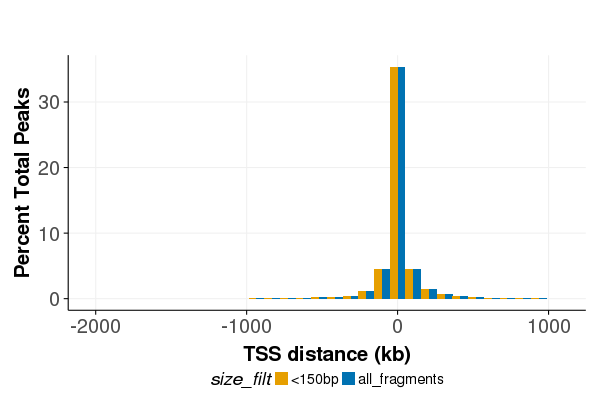

In [11]:
%%R -i df -w 600 -h 400

p2 <- ggplot(df, aes(TSSdist/1000, fill=size_filt)) + 
            geom_histogram(position="dodge", aes((y=c(..count..[..group..==1]/sum(..count..),
                                 ..count..[..group..==2]/sum(..count..))*100), x=TSSdist/1000)) + 
            labs(y="Percent Total Peaks", x="TSS distance (kb)", title="") + 
        theme_Publication() +
        scale_fill_manual(values=Palette)

p2

## Peakcalling QC
### All peaks
* All detected peaks with & without filtering reads by size & fraction of reads in peaks

In [ ]:
peak_stats = DB.fetch_DataFrame('''select a.no_peaks, a.size_filt, b.FRIP, b.sample_id from no_peaks a, 
                                frip_table b where a.sample_id=b.sample_id and a.size_filt=b.size_filt ''', db)

peak_stats = pd.merge(peak_stats, sample_info, how="inner", on="sample_id")

In [ ]:
%%R -i peak_stats  -w 800 -h 350

no_peaks <- ggplot(peak_stats, 
                   aes(y=no_peaks, x=category, fill=condition, 
                       shape=factor(replicate), alpha=size_filt)) + 
                geom_text(aes(label=paste0("r", replicate)), 
                          position=position_dodge(width=1), vjust=-0.5, fontface="bold", size=4.5, show.legend=F) +
                geom_bar(stat="identity", position="dodge") + theme_Publication() +
                theme(axis.text.x=element_blank()) + 
                scale_alpha_discrete(range=c(0.4, 1)) +
                labs(y="No. Peaks", y="", x="") +
                scale_y_continuous(limits=c(0, max(peak_stats$no_peaks))) +
                scale_fill_manual(values=Palette) #+ facet_wrap(~ size_filt)
                
frip_plot <- ggplot(peak_stats, 
                    aes(y=FRIP, x=category, fill=condition,
                        alpha=size_filt)) + 
                geom_text(aes(label=paste0("r", replicate)), 
                          position=position_dodge(width=1), vjust=-0.5, fontface="bold", size=4.5, show.legend=F) +
                geom_bar(stat="identity", position="dodge") + theme_Publication() +
                theme(axis.text.x=element_blank()) + 
                scale_alpha_discrete(range=c(0.4, 1)) +
                labs(y="FRIP", x="") +
                scale_y_continuous(limits=c(0,1)) + 
                scale_fill_manual(values=Palette) +
                guides(colour=guide_legend(override.aes=list(size=6)), 
                       alpha=guide_legend(override.aes=list(size=6))) +
                geom_hline(yintercept=0.2, lty="dashed", colour="black") 

key <- get_legend(frip_plot)

grid.arrange(no_peaks + theme(legend.position="none"), frip_plot + theme(legend.position="none"),
             ncol=2, nrow=1, bottom=key)

### High confidence peaks
* Peaks which are consistent between biological replicates, from size filtered & non- size filtered peak sets

In [ ]:
merged_peaks = DB.fetch_DataFrame('''select * from no_peaks where merged like "%merged" ''', db)

In [ ]:
%%R -i merged_peaks -w 600 -h 400

Palette <- c("#E69F00", "#0072B2", "#D55E00", "#009E73",  "#56B4E9",  "#999999", "#F0E442")

ggplot(merged_peaks, aes(y=no_peaks, x=sample_id, alpha=size_filt, fill=sample_id)) +
    geom_bar(stat="identity", position="dodge") +
    scale_alpha_discrete(range=c(0.4, 1)) +
    scale_fill_manual(values=Palette, guide=FALSE) +
    theme_Publication() +
    labs(x="")

In [ ]:
peaks = glob.glob("macs2.dir/*merged*.bed")
all_peaks = [x for x in peaks if "size_filt" not in x]
sf_peaks = [x for x in peaks if "size_filt" in x]

def cat_df(df_list):

    if "size_filt" in df_list[0]:
        size_filt = "size_filt"
    if "size_filt" not in df_list[0]:
        size_filt = "all"

    dfs = []
    for peaks in df_list:
        df = pd.read_csv(peaks, sep="\t", index_col=None, header=None)
        df.columns = ["chr", "start", "end", "peak_id", "peak_width", "strand", "fold_change", "pvalue", "qvalue", "summit"]
    
        df["sample_id"] = os.path.basename(str(peaks)).split("_")[0]
        df["size_filt"] = size_filt
        
        # drop peaks in chrUn* as these have odd peak widths
        chr_filter = df["chr"].str.contains("chrUn_")
        df = df[~chr_filter]
        dfs.append(df)
        
    dfs = pd.concat(dfs)

    
    dfs = dfs[["chr", "start", "end", "peak_id", "peak_width", "sample_id", "size_filt"]]
    
    return dfs

all_dfs = cat_df(all_peaks)
sf_peaks = cat_df(sf_peaks)
peaks = all_dfs.append(sf_peaks)

In [ ]:
%%R -i peaks -w 800 -h 800

a = ggplot(peaks, aes(y=peak_width, x=size_filt, fill=size_filt)) + 
        geom_violin() +
        geom_boxplot(width=0.1, fill="white") +
        scale_fill_manual(values=Palette) +
        theme_Publication() +
        labs(x="", title="All width distributions") +
        theme(legend.position="none") + facet_wrap(~ sample_id)
        
grid.arrange(a, ncol=1, nrow=1)

b = ggplot(peaks, aes(y=peak_width, x=size_filt, fill=size_filt)) + 
        geom_violin() +
        geom_boxplot(width=0.1, fill="white") +
        coord_cartesian(ylim=c(0, 2000)) +
        scale_fill_manual(values=Palette) +
        theme_Publication() +
        labs(x="", title="Zoomed to 0-2 k.b. region") +
        theme(legend.position="none") + facet_wrap(~ sample_id)
        
grid.arrange(b, ncol=1, nrow=1)

## Data Exploration 
* based on counts over merged peakset
* merged peakset consists of all detected peaks (not only high confidence)
* counts are normalised for sequencing depth, peak width, and upper quantile normalised for between sample comparison

In [ ]:
# annotate counts
counts.columns = sample_info["category"]

### Pearson correlation between nomalised counts in consensus peakset
* clustering with Ward method on Manhattan distances

In [ ]:
%%R -i counts

cm <- data.matrix(log2(counts +1))
m <- cor(cm, method="pearson", use="all")

distr <- dist(m, method="manhattan")
clustr <- hclust(distr, method="ward.D2")
dendr <- as.dendrogram(clustr)
dendr <- dendr %>% sort(type="labels")

distc <- dist(t(m), method="manhattan")
clustc <- hclust(distc, method="ward.D2")
dendc <- as.dendrogram(clustc)
dendc <- rev(dendc) %>% sort(type="labels")

p2 <- Heatmap(m,
       col = colorRamp2(c(min(m), max(m)), c("white", "red")),
       cluster_rows=dendr,
       cluster_columns=dendc,
       column_dend_reorder = FALSE,
       column_dend_height = unit(2, "cm"),
       row_dend_width = unit(2, "cm"),
       row_names_gp=gpar(fontsize=16),
       column_names_gp=gpar(fontsize=16),
       name="Pearson Correlation:",
       heatmap_legend_param=list(legend_direction="horizontal", 
                                  at=c(0.9, 1), 
                                  color_bar = "continuous",
                                  legend_width = unit(5, "cm"), 
                                  title_position = "lefttop",
                                  title_gp=gpar(fontsize=18),
                                  labels_gp=gpar(fontsize=14)),
       )

draw(p2, heatmap_legend_side = "bottom")

### Dimensionality Reduction

In [ ]:
%%R -w 1200 -h 500 -i sample_info,counts

df <- as.data.frame(log2(counts+1))
# df = t(df)
pca <- prcomp(df, scale=F)

pca_plots <- ggplot_prcomp(pca, 
             plots=list("A"=c("PC1","PC2"), "B"=c("PC3", "PC4")),
             sample_information=sample_info, 
             shape="replicate", 
             color="condition",
             size=7,
             nudge_scale_factor=30) 

a <- pca_plots$A + theme_Publication() + 
        scale_colour_manual(values=Palette) + 
        scale_shape_manual(values=c(16,17)) +
        guides(colour=guide_legend(override.aes=list(size=8)), 
               shape=guide_legend(override.aes=list(size=6)))
b <- pca_plots$B + theme_Publication() + 
        scale_colour_manual(values=Palette) + 
        scale_shape_manual(values=c(16,17))
c <- pca_plots$scree + theme_Publication()  + 
        scale_colour_manual(values=Palette) + 
        scale_shape_manual(values=c(16,17))


get_legend <- function(a.gplot){ 
  tmp <- ggplot_gtable(ggplot_build(a.gplot)) 
  leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box") 
  legend <- tmp$grobs[[leg]] 
  return(legend)} 
                        
legend <- get_legend(a)
                      
a <- a + theme(legend.position=c(10, 10)) # dont show legend
b <- b + theme(legend.position=c(10, 10))
                      
lay = rbind(c(1,1,1,2,2,2,3,3,3), 
            c(1,1,1,2,2,2,3,3,3),
            c(1,1,1,2,2,2,3,3,3), 
            c(1,1,1,2,2,2,3,3,3), 
            c(NA,4,4,4,NA,NA,NA,NA,NA))  
                      
grid.arrange(top=textGrob("PCA of Normalised Read Counts Over All Peaks", 
                          gp=gpar(fontfamily="Helvetica", fontface="bold", fontsize=23)),
             a, b, c, legend, layout_matrix=lay)

In [ ]:
%%R -h 500 -w 500

log2counts <- as.data.frame(log2(counts+1))
                           
tsne_out <- Rtsne(t(log2counts), pca=T, perplexity=2)
tsne_df <- as.data.frame(tsne_out$Y)
rownames(tsne_df) <- colnames(log2counts)
colnames(tsne_df) <- c("tSNE1", "tSNE2")
tsne_df$category <- rownames(tsne_df)

tsne_df <- merge(tsne_df, sample_info, by="category")

p <- ggplot(tsne_df, aes(y=tSNE1, x=tSNE2, shape=replicate, colour=condition)) + 
        geom_point(size=7) + 
        theme_Publication()  + 
        scale_colour_manual(values=Palette) + 
        scale_shape_manual(values=c(16,17)) +
        labs(title="tSNE of Normalised Read Counts \nOver All Peaks")

grid.arrange(p, ncol=1, nrow=1)

### Replicate correlation

In [ ]:
# use sample information to get no. replicates & conditions
rep_pairs = sample_info.pivot("condition", "replicate", "category").transpose()
rep_pairs.columns.name = None
rep_pairs.index.name = None

# report replicates to dict
reps = {}
for col in rep_pairs.columns:
    reps[col]=[rep_pairs[col].iloc[0], rep_pairs[col].iloc[1]]
    
sns.set(style="whitegrid", palette="muted")# set seaborn theme

# use dict to subset df of normalised counts & plot rep correlations
n = 0
palette = ["b", "g", "r", "c", "m", "y", "k", "w"]
for key in reps:
    n = n + 1
    c = n - 1
    df = counts[reps[key]]
    df.columns = ["Rep1", "Rep2"]
    p = sns.jointplot(data=df, y="Rep1", x="Rep2", kind="reg", size=7, color=palette[c])
    plt.subplots_adjust(top=0.9)
    p.fig.suptitle(key) # add title
    plt.show()